In [1]:
# Load .env variables
from dotenv import load_dotenv
import os

load_dotenv()
CHURN_THRESHOLD_DAYS = int(os.getenv("CHURN_THRESHOLD_DAYS", 90))
DOWNLOAD_PATH = os.getenv("DOWNLOAD_PATH", "./data")

In [2]:
# Download computingvictor/transactions-fraud-datasets from Kaggle

import kaggle

dataset_slug = "computingvictor/transactions-fraud-datasets"

print(f"Downloading {dataset_slug}...")
kaggle.api.dataset_download_files(dataset_slug, path=DOWNLOAD_PATH, unzip=True)

Dataset URL: https://www.kaggle.com/datasets/computingvictor/transactions-fraud-datasets


In [3]:
import pandas as pd
import json

def clean_currency(x):
    """
    Input:  "$-1,234.50" (str)
    Output: -1234.50 (float)
    """
    if not x: return 0.0  # Handle empty values
    
    # Remove symbol '$' and separator ',' 
    # then convert to float
    return float(x.replace('$', '').replace(',', ''))

# Load into Pandas
df_cards = pd.read_csv(
    f"{DOWNLOAD_PATH}/cards_data.csv",
    parse_dates=['expires', 'acct_open_date'],
    date_format='%m/%Y',
    converters={
        'credit_limit': clean_currency,
    }
)
df_transactions = pd.read_csv(
    f"{DOWNLOAD_PATH}/transactions_data.csv",
    parse_dates=['date'],
    converters={
        'amount': clean_currency
    }
)
df_users = pd.read_csv(
    f"{DOWNLOAD_PATH}/users_data.csv",
    converters={
        'per_capita_income': clean_currency,
        'yearly_income': clean_currency,
        'total_debt': clean_currency
    }
)
# Load mcc_codes.json, and turn it into a Pandas DataFrame
with open(f"{DOWNLOAD_PATH}/mcc_codes.json") as f:
    mcc_codes = json.load(f)
df_mcc_codes = pd.DataFrame(list(mcc_codes.items()), columns=['mcc', 'merchant_category'])
df_mcc_codes['mcc'] = df_mcc_codes['mcc'].astype(int)

In [4]:
print(f"Total Users: {df_users['id'].nunique()}")
print(f"Total Cards: {df_cards['id'].nunique()}")
print(f"Users with Transactions: {df_transactions['client_id'].nunique()}")
print(f"Cards with Transactions: {df_transactions['card_id'].nunique()}")

Total Users: 2000
Total Cards: 6146
Users with Transactions: 1219
Cards with Transactions: 4071


In [5]:
# Merge users, transactions, and cards data - users uses id, transactions uses user_id and card_id
df = df_transactions.merge(df_users, left_on='client_id', right_on='id', suffixes=('_transaction', '_user'))
df = df.merge(df_cards, left_on='card_id', right_on='id', suffixes=('', '_card'))
# Merge mcc_codes on mcc
# mcc_codes is structured as:
#
# {
#   "1711": "Heating, Plumbing, Air Conditioning Contractors",
#   "3000": "Steelworks",
#   "3001": "Steel Products Manufacturing"
#   }
df = df.merge(df_mcc_codes, left_on='mcc', right_on='mcc', how='left')

print(f"Final shape: {df.shape}")
df.head()

Final shape: (13305915, 40)


,id_transaction,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web,merchant_category
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,...,5497590243197280,2022-07-01,306,YES,2,55.0,2008-05-01,2008,No,Miscellaneous Food Stores
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,...,5175842699412235,2024-12-01,438,YES,1,9100.0,2005-09-01,2015,No,Department Stores
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,...,5874992802287595,2020-05-01,256,YES,1,14802.0,2006-01-01,2008,No,Money Transfer
3,7475331,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,...,5346827663529174,2024-10-01,54,NO,2,37634.0,2004-05-01,2006,No,Money Transfer
4,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,...,4354185735186651,2020-01-01,120,YES,1,19113.0,2009-07-01,2014,No,Drinking Places (Alcoholic Beverages)


In [6]:
# Print list of columns
for c in df.columns.tolist():
    print(f"{c} (type:{df[c].dtype}),")

id_transaction (type:int64),
date (type:datetime64[ns]),
client_id (type:int64),
card_id (type:int64),
amount (type:float64),
use_chip (type:object),
merchant_id (type:int64),
merchant_city (type:object),
merchant_state (type:object),
zip (type:float64),
mcc (type:int64),
errors (type:object),
id_user (type:int64),
current_age (type:int64),
retirement_age (type:int64),
birth_year (type:int64),
birth_month (type:int64),
gender (type:object),
address (type:object),
latitude (type:float64),
longitude (type:float64),
per_capita_income (type:float64),
yearly_income (type:float64),
total_debt (type:float64),
credit_score (type:int64),
num_credit_cards (type:int64),
id (type:int64),
client_id_card (type:int64),
card_brand (type:object),
card_type (type:object),
card_number (type:int64),
expires (type:datetime64[ns]),
cvv (type:int64),
has_chip (type:object),
num_cards_issued (type:int64),
credit_limit (type:float64),
acct_open_date (type:datetime64[ns]),
year_pin_last_changed (type:int64),
ca

## Synthethising a churn label

Since this is a credit card/transactional dataset, we don't have an explicit "Contract Cancelled" event (like ending a Netflix subscription). Instead, we are looking for **"Silent Churn"** (or Dormancy). This occurs when a customer simply stops using the card without telling the bank.

Here is the industry-standard way to engineer this feature: **The "Recency" Threshold**.

**The Logic**

We define a "Cutoff Date" (usually the last day available in the dataset). If a user has not made a single transaction within **X days** of that cutoff, they are flagged as Churn.

**Active**: Transacted recently (e.g., last 90 days).

**Churned**: Last transaction was > 90 days ago.

In [7]:
# Find the "Anchor Date" (The last day data was collected)
# In a real scenario, this would be "today", but for historical data, 
# we use the max date in the dataset.
anchor_date = df['date'].max()
print(f"Dataset ends on: {anchor_date}")

print(f"Churn Threshold (days): {CHURN_THRESHOLD_DAYS}")

# Calculate the last transaction date per user
# We group by 'id_user' to find their specific last active moment
last_tx_per_user = df.groupby('id_user')['date'].max().reset_index()
last_tx_per_user.rename(columns={'date': 'last_tx_date'}, inplace=True)

# Calculate "Days Since Last Transaction" (Recency)
last_tx_per_user['days_since_last_tx'] = (anchor_date - last_tx_per_user['last_tx_date']).dt.days

# Compute churn label based on threshold
last_tx_per_user['churned'] = (last_tx_per_user['days_since_last_tx'] > CHURN_THRESHOLD_DAYS).astype(int)

# Merge this label back into the main dataframe
# Now every transaction row knows if that user eventually churned
df = df.merge(last_tx_per_user[['id_user', 'churned', 'days_since_last_tx']], on='id_user', how='left')

Dataset ends on: 2019-10-31 23:59:00
Churn Threshold (days): 30


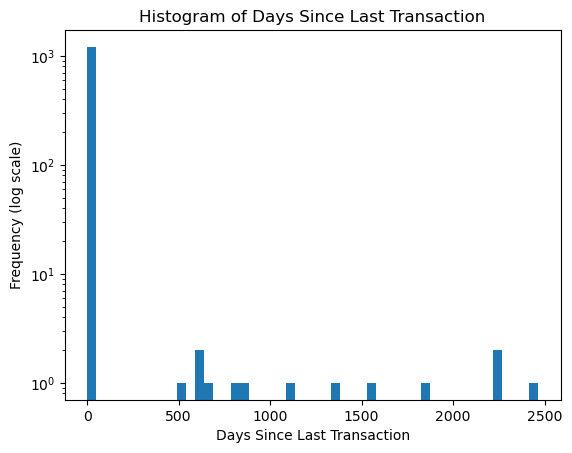

count    1219.000000
mean       14.091879
std       150.981745
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      2464.000000
Name: days_since_last_tx, dtype: float64


In [8]:
# Plot the histogram for days_since_last_tx, make the scale logarithmic
import matplotlib.pyplot as plt

plt.hist(last_tx_per_user['days_since_last_tx'], bins=50, log=True)
plt.title('Histogram of Days Since Last Transaction')
plt.xlabel('Days Since Last Transaction')
plt.ylabel('Frequency (log scale)')
plt.show()

# Print the days_since_last_tx statistics
print(last_tx_per_user['days_since_last_tx'].describe())

In [9]:
# Total unique people
unique_people = df['id_user'].nunique()
# Count number of people with at least one card which churned
per_churn = df.groupby('churned')['id_user'].nunique()
print(f"Ratio of unique people churned vs total: {per_churn[1]}/{unique_people} = {per_churn[1]/unique_people:.2%}")

Ratio of unique people churned vs total: 16/1219 = 1.31%


In [10]:
# Total unique cards
unique_cards = df['card_id'].nunique()
# Count number of unique cards which churned
per_churn_cards = df.groupby('churned')['card_id'].nunique()
print(f"Ratio of unique cards churned vs total: {per_churn_cards[1]}/{unique_cards} = {per_churn_cards[1]/unique_cards:.2%}")

Ratio of unique cards churned vs total: 24/4071 = 0.59%


In [11]:
# Write final dataframe to CSV
df.to_csv(f"processed_transactions_data.csv", index=False)